## Simulations
We simulate an FeGe disk of diameter 160 nm and thickness 10 nm in a varying external field ($\mu_{0}$**H**) from 0 T to 1.2 T. The simulations start from multiple initial configurations.
### Initial configurations

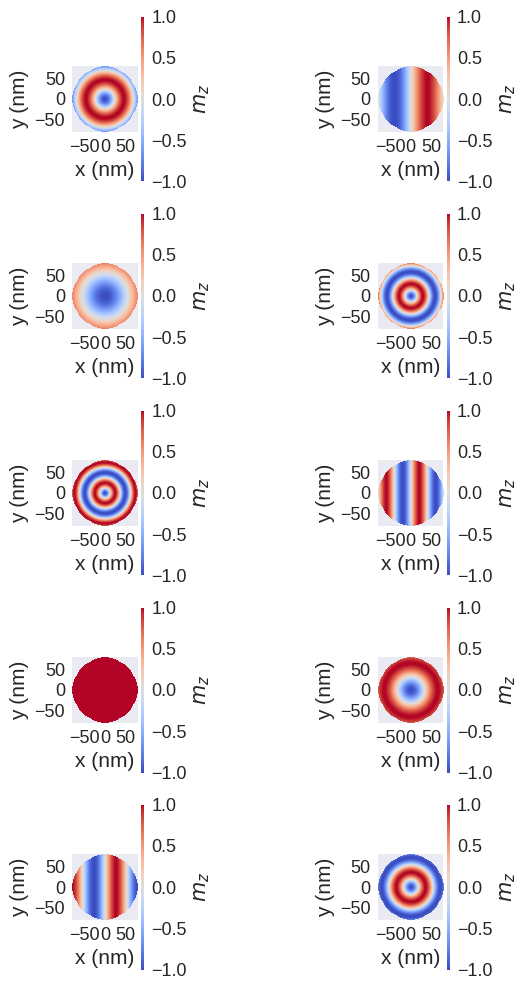

In [51]:
%matplotlib inline
import pathlib as pl

import discretisedfield as df
import matplotlib.pyplot as plt

paths = pl.Path("sims/Configs_0/").glob("drive-[0-9]/m0.omf")
fig, ax = plt.subplots(nrows=5, ncols=2)
for i, path in enumerate(paths):
    row, column = divmod(i, 2)
    field = df.Field.from_file(path).orientation
    field.valid = "norm"
    field.z.sel("z").mpl.scalar(
        ax=ax[row, column], clim=(-1, 1), cmap="coolwarm", colorbar_label="$m_z$",
    )
fig.set_size_inches(7, 10)
plt.tight_layout()
plt.show()

### Energy contributions
$E = \int_V \biggl[ - A \mathbf{m} \cdot \nabla^{2} \mathbf{m} + D \mathbf{m} \cdot (\nabla \times \mathbf{m}) -\mu_{0}M_\text{s} \mathbf{m} \cdot \mathbf{H}-\frac{1}{2}\mu_{0}M_\text{s} \mathbf{m} \cdot \mathbf{H}_\text{d} \biggr] \textrm{d}V$

The equilibrium configurations are obtained by minimizing the energy.

## Training the CNN auto-encoder
The network topology:
<div>
<img src="images/autoencoder.png" width="700"/>
</div>

In [52]:
import numpy as np
import tensorflow.keras as ks
from sklearn.model_selection import train_test_split

In [53]:
simulation_file_paths = list(
    pl.Path("sims").glob("Configs_*/drive-[0-9]/Configs_*.omf")
)

In [54]:
sim_arr = np.array([df.Field.from_file(file).orientation.sel("z").array for file in simulation_file_paths])

In [55]:
import json


parameters_dict = {}
for path in simulation_file_paths:
    json_file_path = path.parent / "parameters_DE.json"
    with open(json_file_path, "r", encoding="utf-8") as f_handle:
        parameters_dict[str(path)] = json.load(f_handle)

In [56]:
train_set, test_set = train_test_split(sim_arr, test_size=0.2, random_state=42)
train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=42)

In [57]:
print(train_set.shape[0], valid_set.shape[0], test_set.shape[0])

1926 482 602


In [58]:
encoder = ks.models.Sequential(
    [
        ks.layers.InputLayer(input_shape=(80, 80, 3)),
        ks.layers.MaxPool2D(pool_size=2),
        ks.layers.Conv2D(
            3,
            kernel_size=8,
            strides=1,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(40, 40, 3),
        ),
        ks.layers.MaxPool2D(pool_size=2),
        ks.layers.Conv2D(
            3,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(20, 20, 3),
        ),
        ks.layers.MaxPool2D(pool_size=2),
        ks.layers.Conv2D(
            6,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(10, 10, 3),
        ),
        ks.layers.MaxPool2D(pool_size=2),
        ks.layers.Conv2D(
            12,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(5, 5, 6),
        ),
        ks.layers.MaxPool2D(pool_size=5),  # image size 1 X 1 x 12
    ],
    name="encoder",
)

In [59]:
decoder = ks.models.Sequential(
    [
        ks.layers.Conv2DTranspose(
            6,
            kernel_size=4,
            strides=5,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(1, 1, 12),
        ),
        ks.layers.Conv2DTranspose(
            3,
            kernel_size=4,
            strides=2,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(5, 5, 6),
        ),
        ks.layers.Conv2DTranspose(
            3,
            kernel_size=4,
            strides=2,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(10, 10, 3),
        ),
        ks.layers.Conv2DTranspose(
            3,
            kernel_size=4,
            strides=2,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(20, 20, 3),
        ),
        ks.layers.Conv2DTranspose(
            3,
            kernel_size=8,
            strides=2,
            padding="same",
            activation="selu",
            kernel_initializer="lecun_normal",
            input_shape=(80, 80, 3),
        ),
    ],
    name="decoder",
)

In [60]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 max_pooling2d_5 (MaxPoolin  (None, 40, 40, 3)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 3)         579       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 20, 20, 3)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 3)         147       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 10, 10, 3)         0         
 g2D)                                                            
                                                           

In [61]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_5 (Conv2D  (None, 5, 5, 6)           1158      
 Transpose)                                                      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 10, 10, 3)         291       
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 20, 20, 3)         147       
 Transpose)                                                      
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 40, 40, 3)         147       
 Transpose)                                                      
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 80, 80, 3)         579 

In [62]:
auto_encoder = ks.models.Sequential([encoder, decoder], name="autoencoder")

In [63]:
auto_encoder.compile(
    loss="MSE",
    optimizer=ks.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
)

In [64]:
history = auto_encoder.fit(
    train_set, train_set, epochs=15, validation_data=(valid_set, valid_set)
)

Epoch 1/15


61/61 [==============================] - 3s 37ms/step - loss: 0.2151 - val_loss: 0.1341
Epoch 2/15
61/61 [==============================] - 2s 34ms/step - loss: 0.0946 - val_loss: 0.0604
Epoch 3/15
61/61 [==============================] - 2s 33ms/step - loss: 0.0506 - val_loss: 0.0411
Epoch 4/15
61/61 [==============================] - 2s 34ms/step - loss: 0.0370 - val_loss: 0.0315
Epoch 5/15
61/61 [==============================] - 2s 34ms/step - loss: 0.0297 - val_loss: 0.0271
Epoch 6/15
61/61 [==============================] - 2s 34ms/step - loss: 0.0262 - val_loss: 0.0245
Epoch 7/15
61/61 [==============================] - 2s 33ms/step - loss: 0.0242 - val_loss: 0.0231
Epoch 8/15
61/61 [==============================] - 2s 34ms/step - loss: 0.0228 - val_loss: 0.0221
Epoch 9/15
61/61 [==============================] - 2s 34ms/step - loss: 0.0219 - val_loss: 0.0212
Epoch 10/15
61/61 [==============================] - 2s 33ms/step - loss: 0.0211 - val_loss: 0.0208
Epoch 11/15
61/61 [=

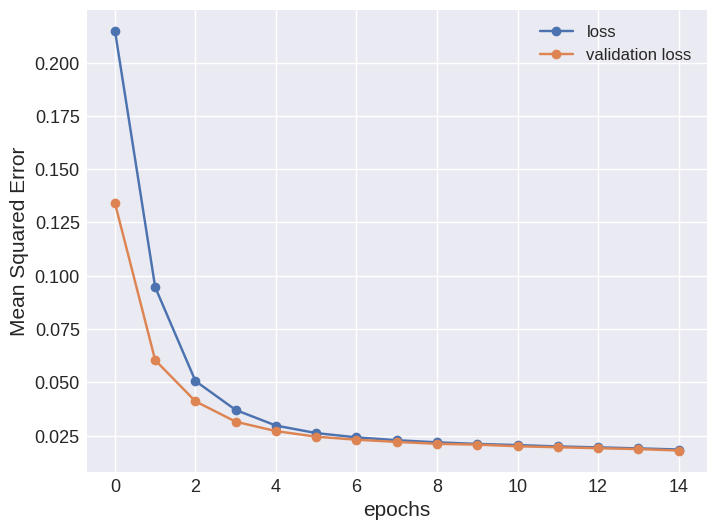

In [65]:
plt.plot(history.history["loss"], "-o", label="loss")
plt.plot(history.history["val_loss"], "-o", label="validation loss")
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid()
plt.show()

In [66]:
auto_encoder.evaluate(test_set, test_set)

19/19 [==============================] - 0s 13ms/step - loss: 0.0186


0.018582141026854515

### Autoencoder visualisation

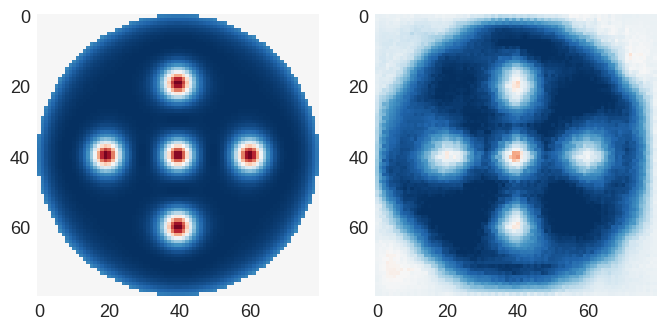

In [67]:
i = 25
in_sim = test_set[i : i + 1]
out_sim = auto_encoder(in_sim)
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(in_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")
ax[1].imshow(out_sim[0, ..., 2], vmin=-1, vmax=1, cmap="RdBu")

## Feature extractor

In [68]:
feature_extractor = ks.models.Sequential(
    [
        auto_encoder.get_layer("encoder"),
        ks.layers.Flatten(),
    ]
)

In [69]:
feat_shape = auto_encoder.get_layer("encoder").output_shape[-1]

In [70]:
feature_arr = feature_extractor.predict(sim_arr, verbose=2)

95/95 - 1s - 663ms/epoch - 7ms/step


## Clustering

In [71]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [72]:
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(feature_arr)
distances, indices = neighbors_fit.kneighbors(feature_arr)

In [73]:
distances_sorted = np.sort(distances, axis=0)

In [74]:
import plotly.graph_objs as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = list(range(distances_sorted.shape[0])),
        y = distances_sorted[:, -1],
        mode="markers",
    )
)
fig.update_layout(
    autosize=False,
    width=990,
    height=300,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=25,
    ),
    xaxis_title="Instance",
    yaxis_title="Euclidian distance",
)

In [75]:
#dbscan = DBSCAN(eps=0.64, min_samples=5)

In [120]:
# hyperparameter optimization
import optuna
from sklearn.metrics import silhouette_score


def objective(trial):
    eps = trial.suggest_float("eps", 0.5, 1.5)
    min_samples = trial.suggest_int("min_samples", 2, 10)
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(feature_arr)
    metric = silhouette_score(feature_arr, labels)
    return metric

#search_space = {"eps": (0.5, 1.5), "min_samples": (2, 10)}
study = optuna.create_study(direction="maximize")
print(f"Sampler is {study.sampler.__class__.__name__}")
study.optimize(objective, n_trials=100)

[I 2024-03-06 15:05:22,546] A new study created in memory with name: no-name-d04caaa6-4e94-4cb6-b7bd-1622ec5cd0b4


Sampler is TPESampler


[I 2024-03-06 15:05:22,771] Trial 0 finished with value: 0.23089668154716492 and parameters: {'eps': 1.0931255570293366, 'min_samples': 6}. Best is trial 0 with value: 0.23089668154716492.
[I 2024-03-06 15:05:22,939] Trial 1 finished with value: 0.31766852736473083 and parameters: {'eps': 0.640877430757692, 'min_samples': 7}. Best is trial 1 with value: 0.31766852736473083.
[I 2024-03-06 15:05:23,118] Trial 2 finished with value: 0.31660017371177673 and parameters: {'eps': 0.8633095550536304, 'min_samples': 10}. Best is trial 1 with value: 0.31766852736473083.
[I 2024-03-06 15:05:23,272] Trial 3 finished with value: 0.31675004959106445 and parameters: {'eps': 0.5710108675813896, 'min_samples': 7}. Best is trial 1 with value: 0.31766852736473083.
[I 2024-03-06 15:05:23,440] Trial 4 finished with value: 0.23237892985343933 and parameters: {'eps': 1.3766905389857378, 'min_samples': 10}. Best is trial 1 with value: 0.31766852736473083.
[I 2024-03-06 15:05:23,594] Trial 5 finished with valu

In [121]:
# plot hyperparameter vs metric
import optuna.visualization as vis

vis.plot_optimization_history(study)

In [122]:
print(study.best_params)
dbscan = DBSCAN(eps=study.best_params["eps"], min_samples=5)


{'eps': 0.6917387379229747, 'min_samples': 7}


In [123]:
dbscan.fit(feature_arr)
dbscan.labels_.max()

12

## Comparing results

In [124]:
class_dict = {f"Class {i}": list() for i in range(dbscan.labels_.max() + 1)}
class_dict["Outliers"] = list()
for index, path in enumerate(simulation_file_paths):
    class_ = dbscan.labels_[index]
    if class_ == -1:
        class_dict["Outliers"].append(str(path))
    else:
        class_dict[f"Class {class_}"].append(str(path))

In [125]:
import plotly.graph_objs as go
import plotly.express as ptx


traces = list()
for class_id, colour in zip(class_dict, ptx.colors.qualitative.Dark24):
    traces.append(
        go.Scatter(
            x=[
                parameters_dict[f]["H"]
                for f in class_dict[class_id]
            ],
            y=[
                parameters_dict[f]["E"]
                for f in class_dict[class_id]
            ],
            mode="markers",
            name=class_id,
            opacity=0.7,
            marker=dict(
                size=11,
                color=colour,
            ),
        )
    )

fig = go.Figure(data=traces)
fig.update_layout(
    autosize=False,
    width=990,
    height=600,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=25,
    ),
    xaxis_title=r"$\mu_0 \mathbf{H} \text{ (T)}$",
    yaxis_title=r"$\Delta \text{E (J)}$",
)

![Published results](images/phase-paper.jpg)

In [126]:
from plotting import plot_all_examples

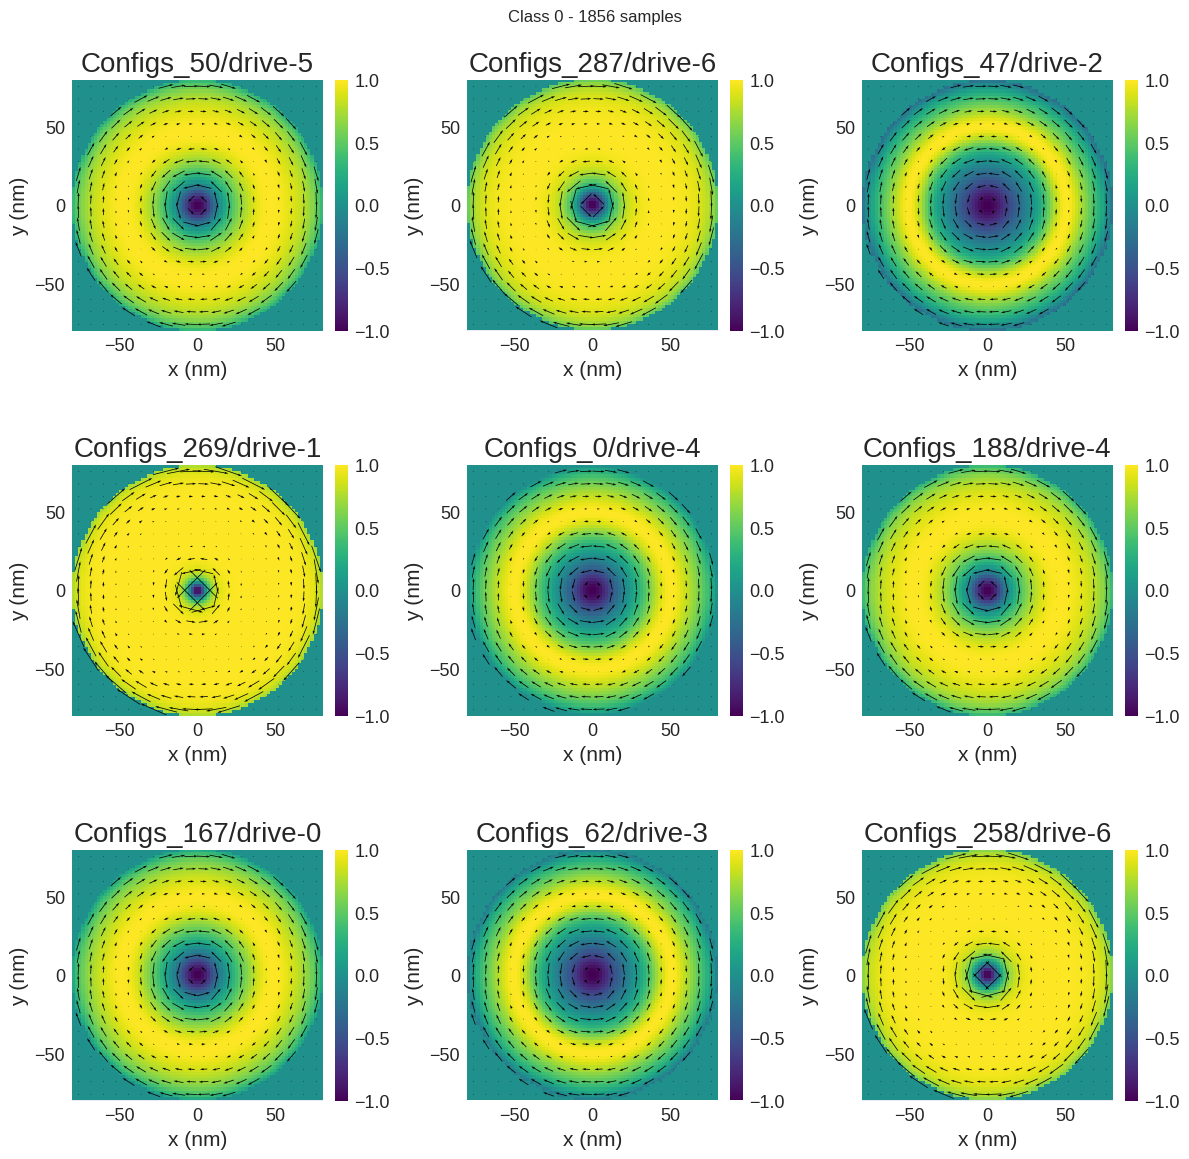

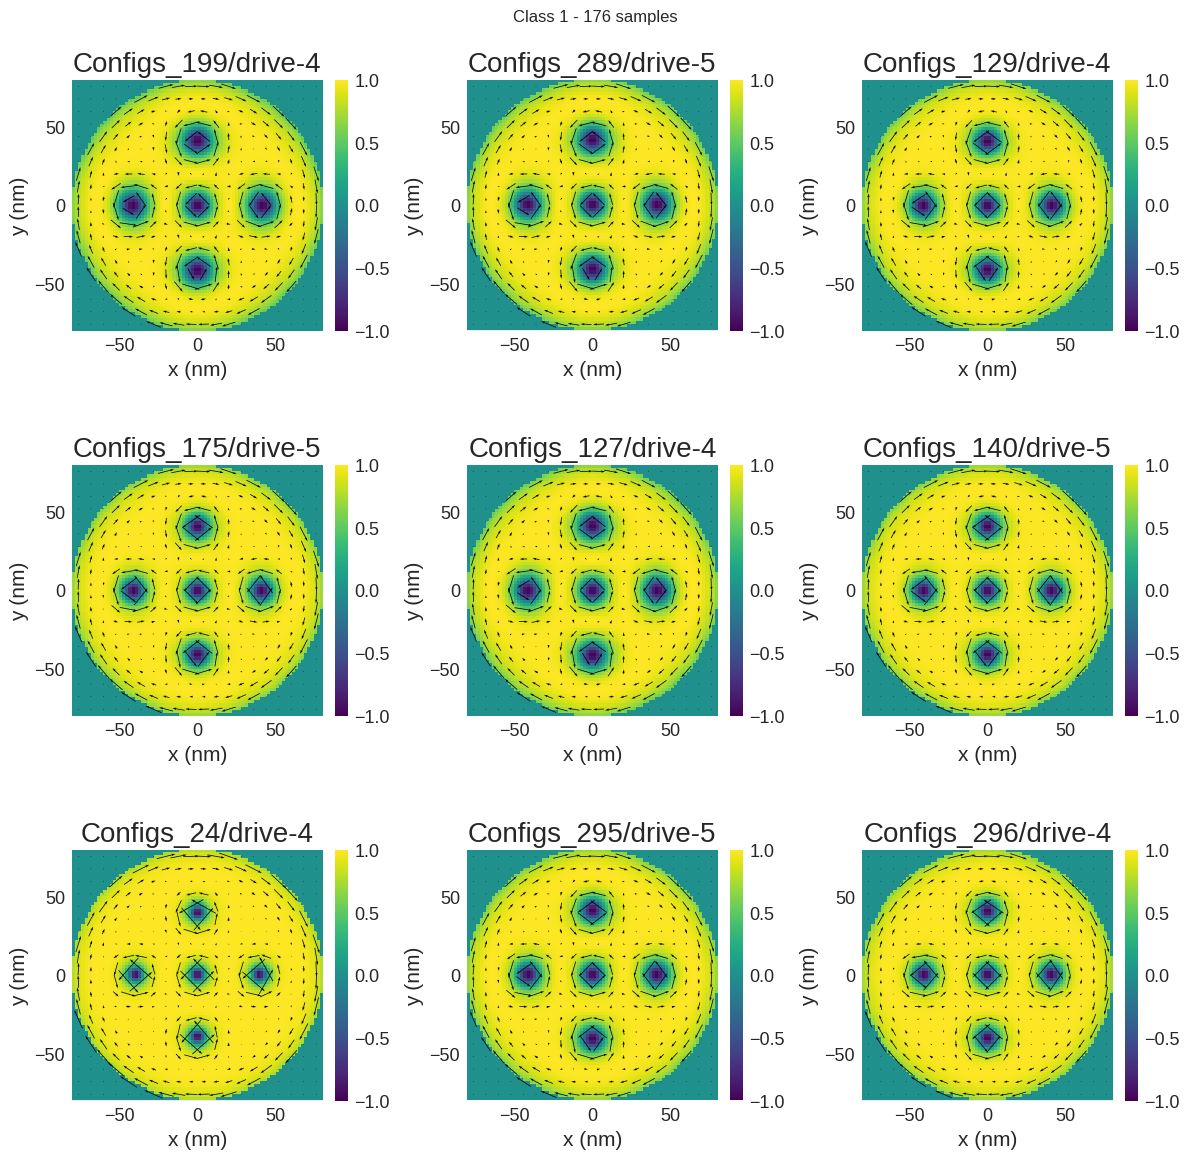

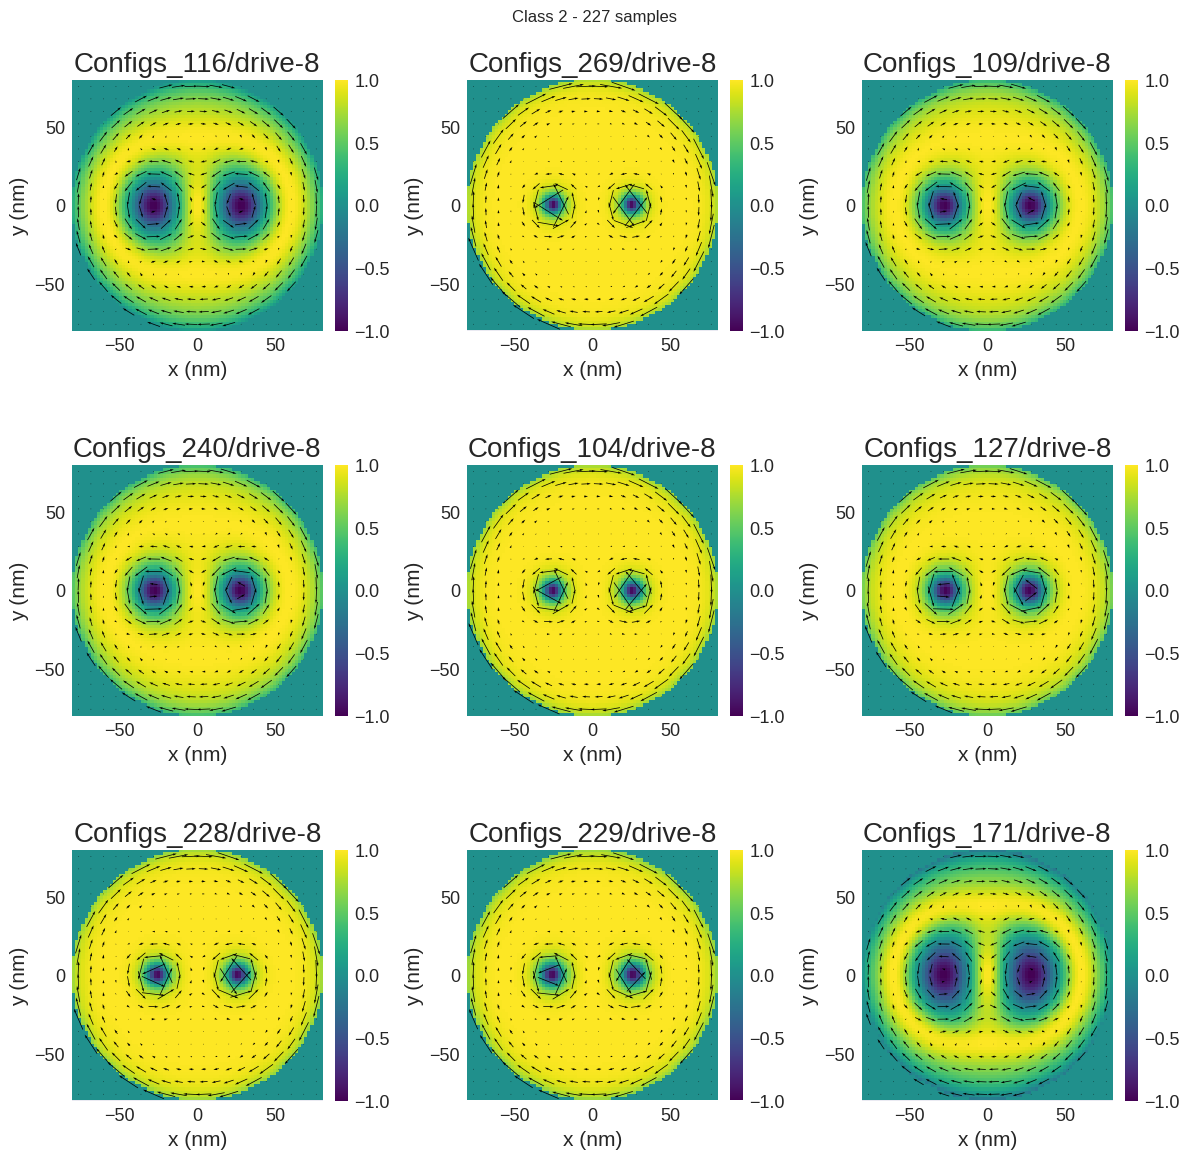

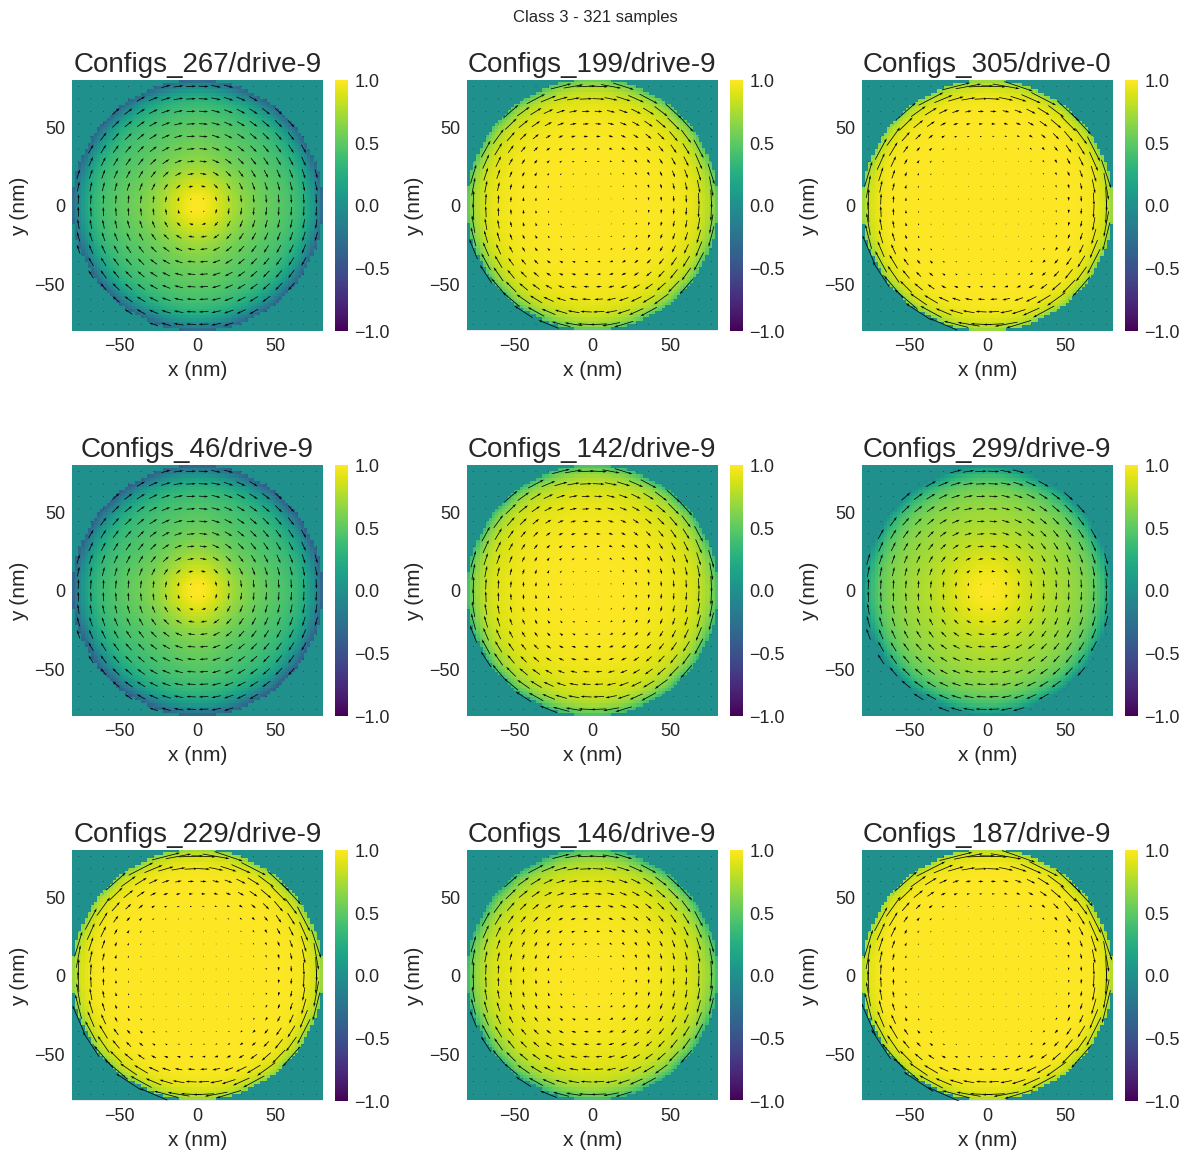

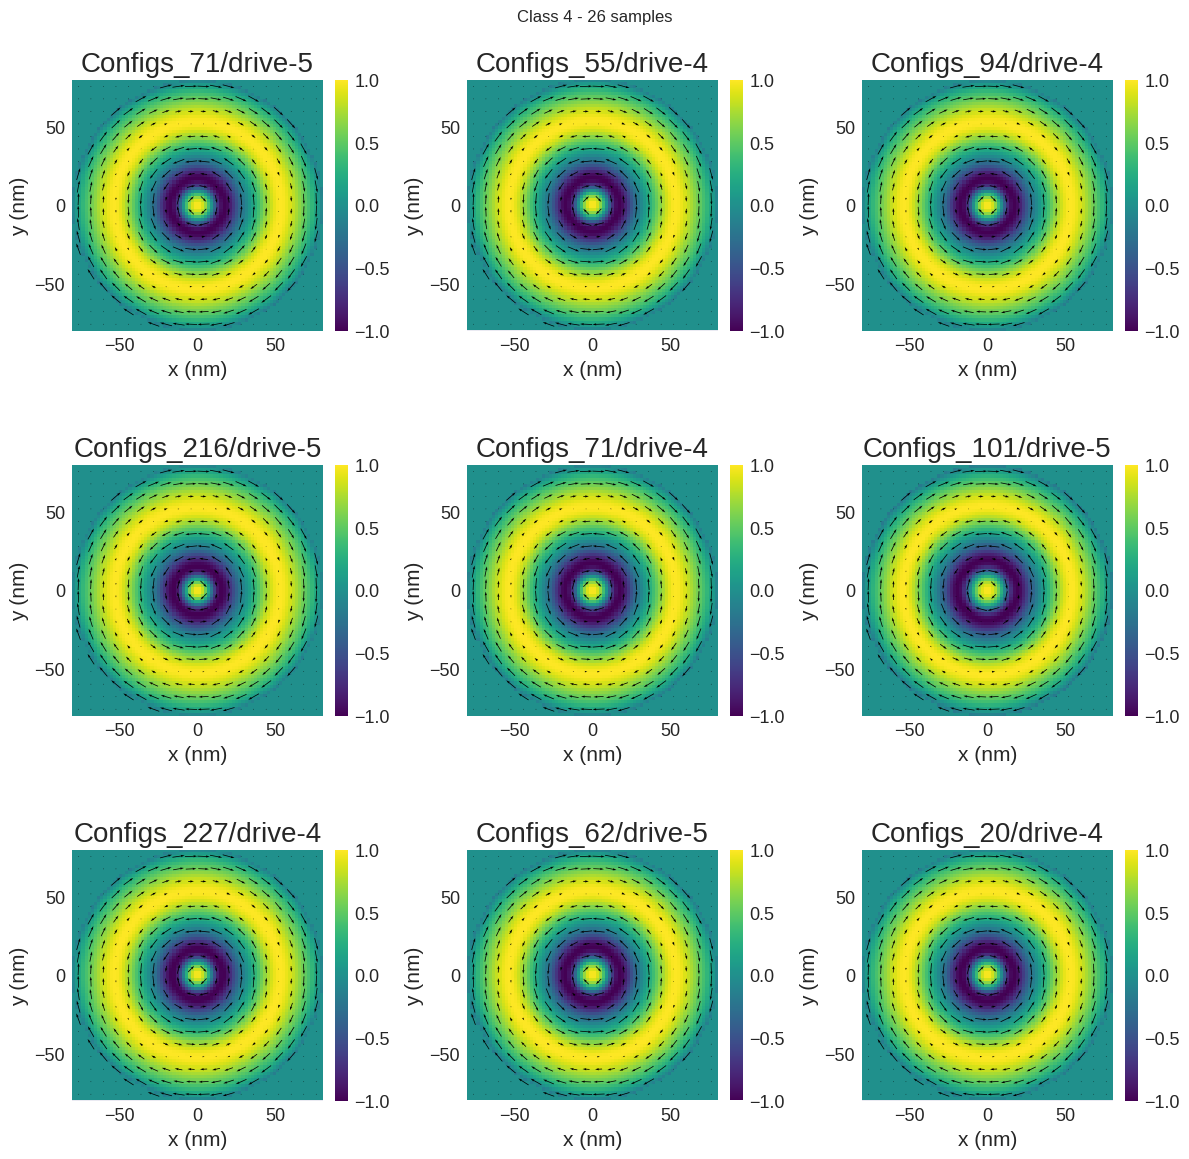

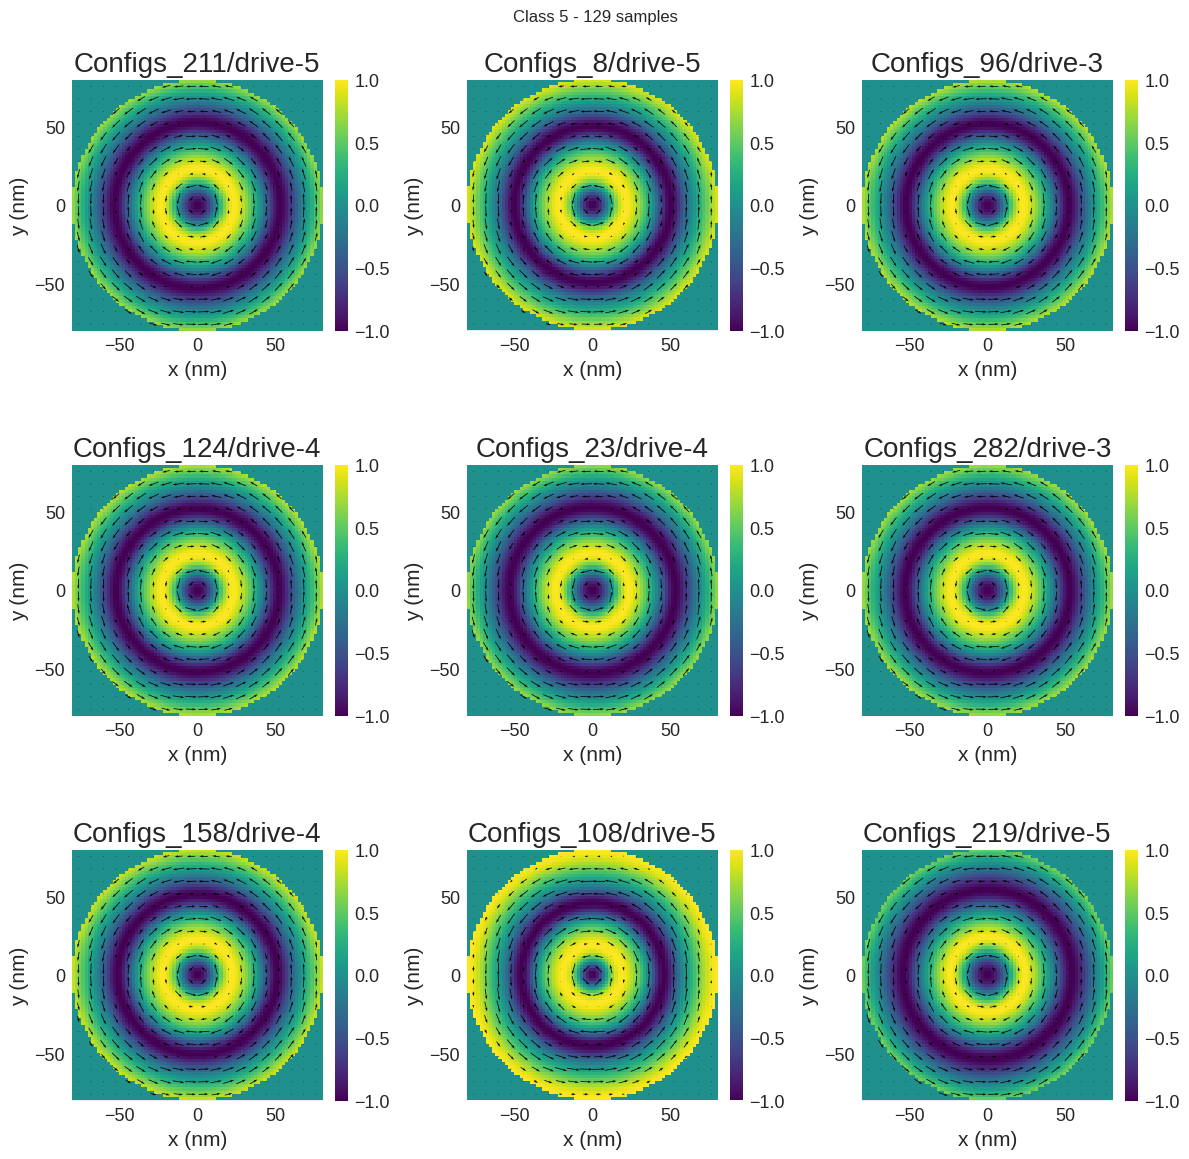

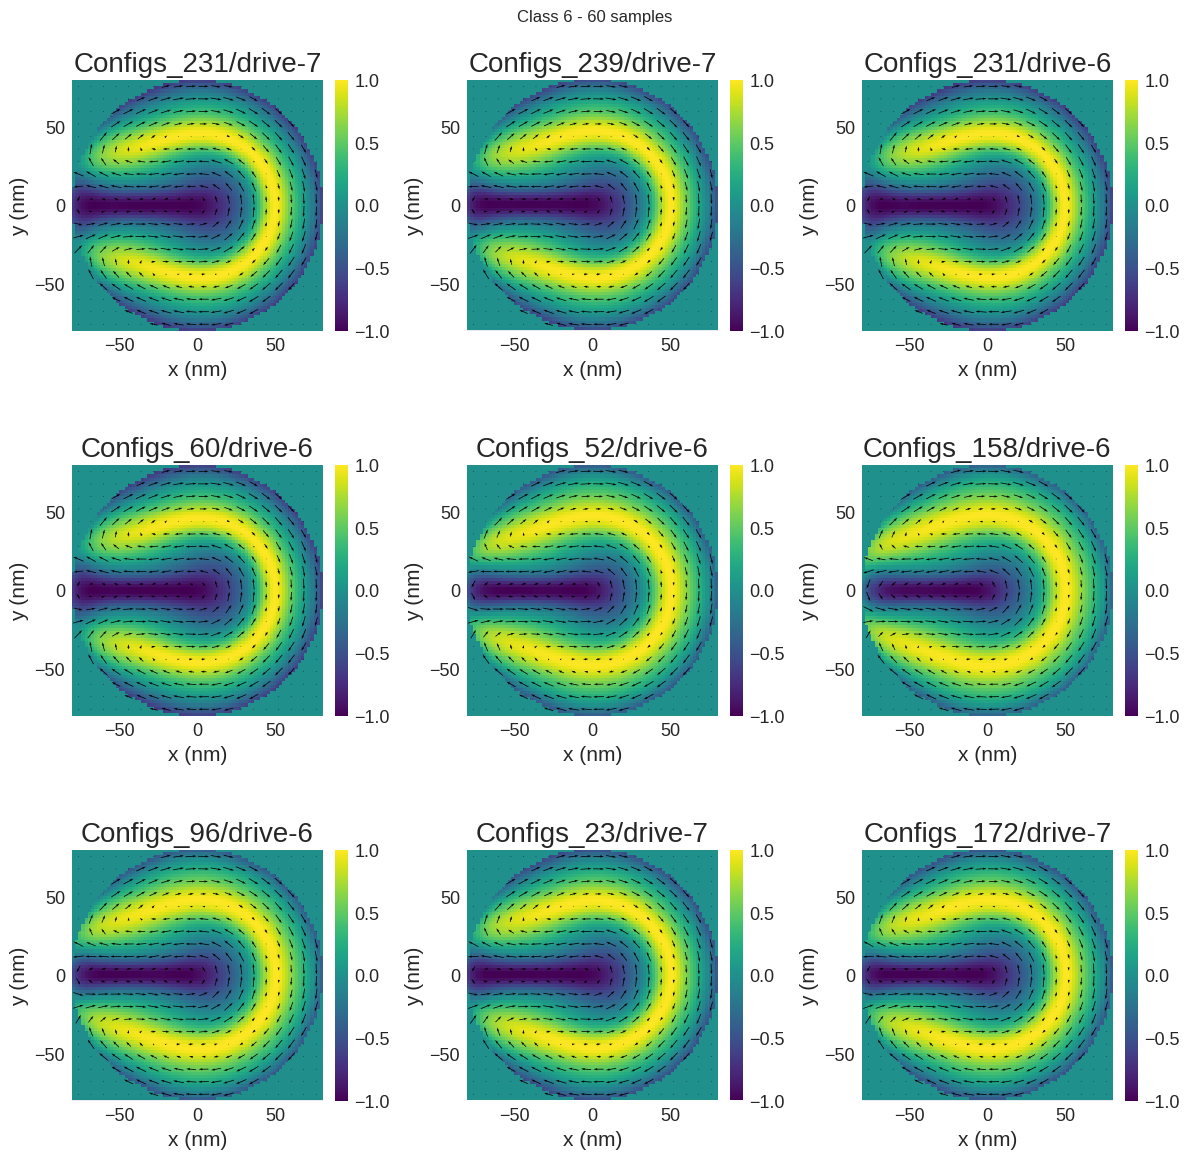

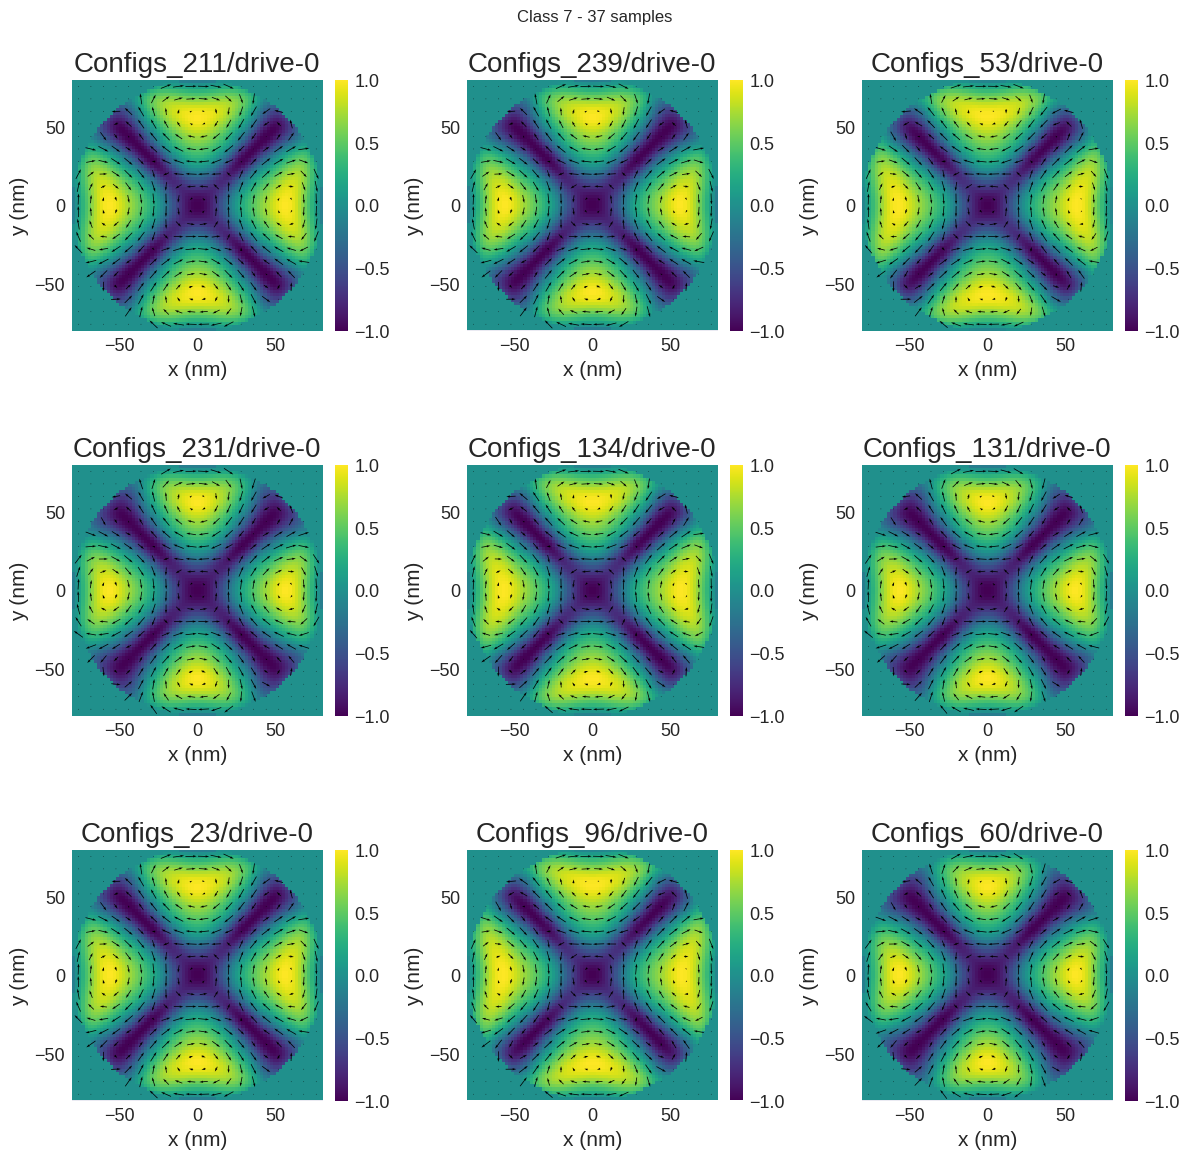

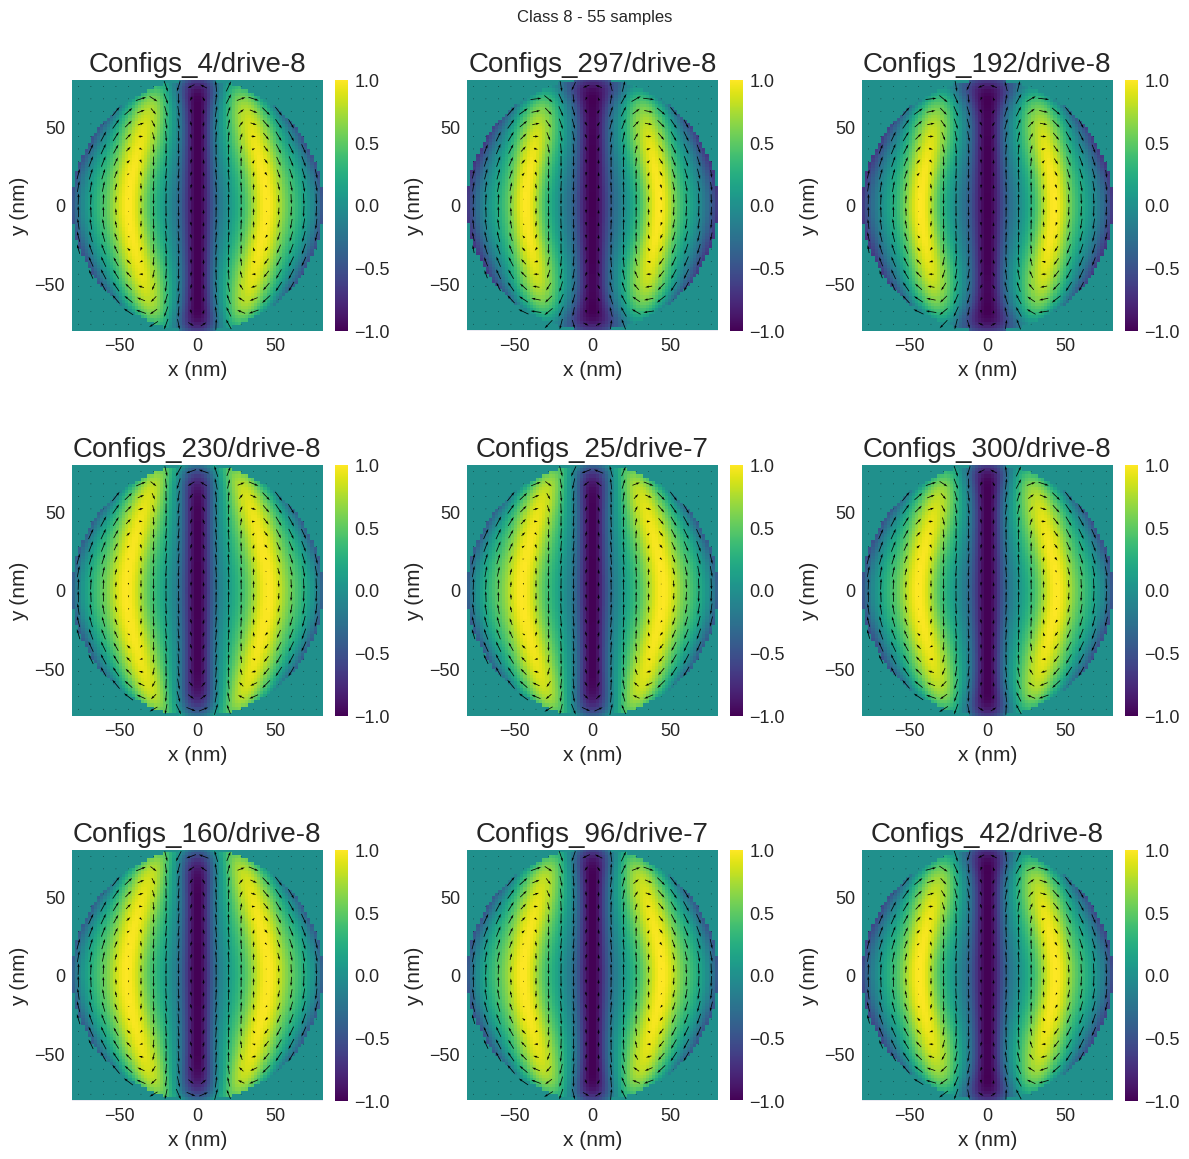

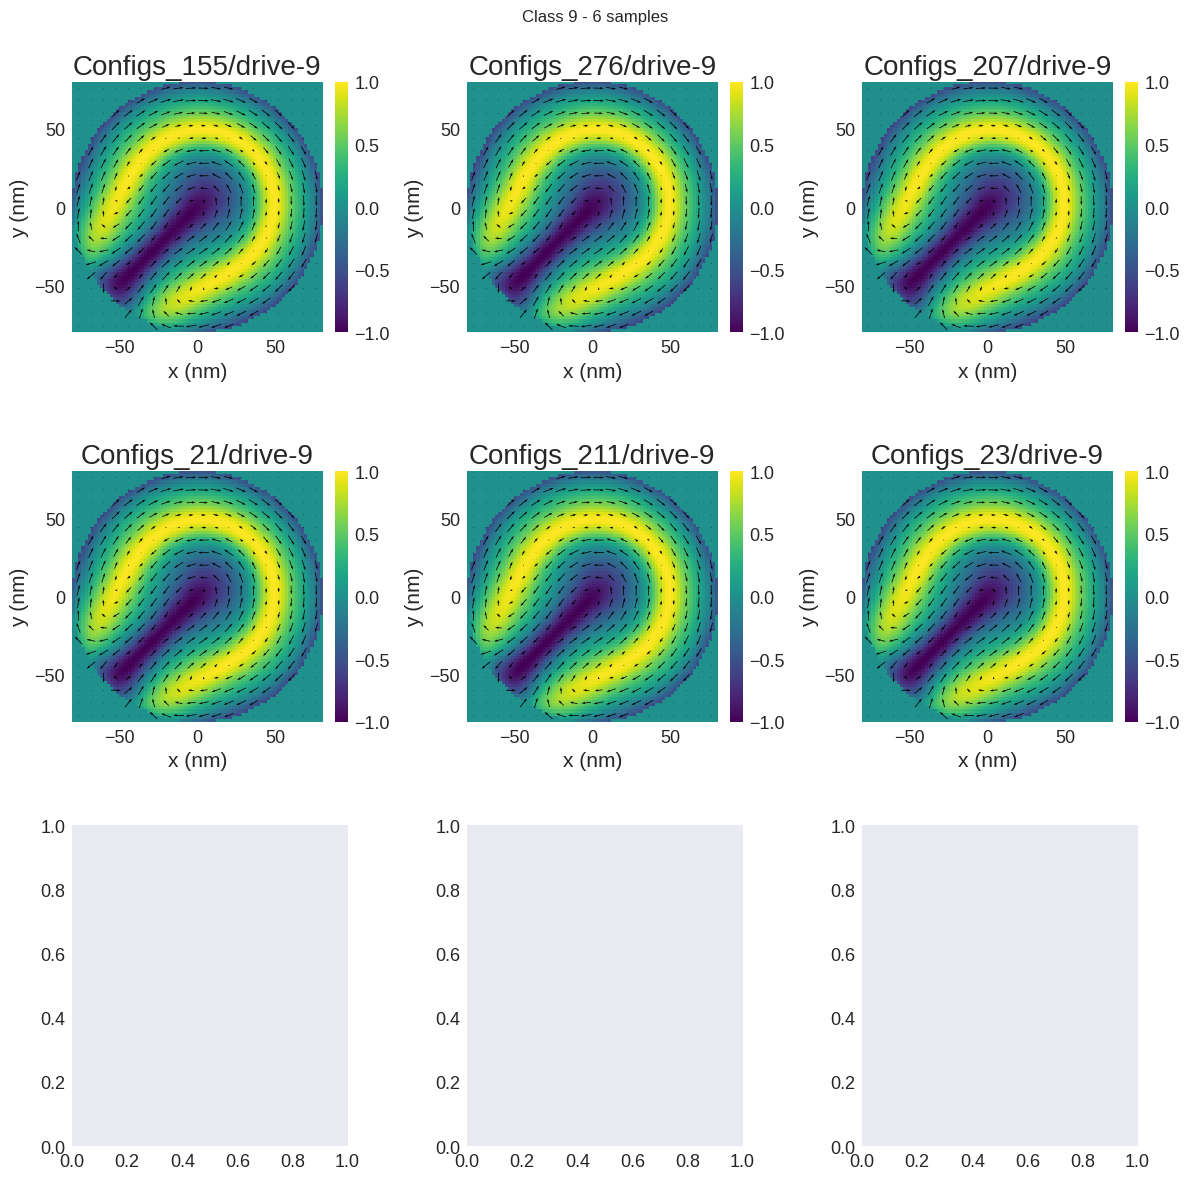

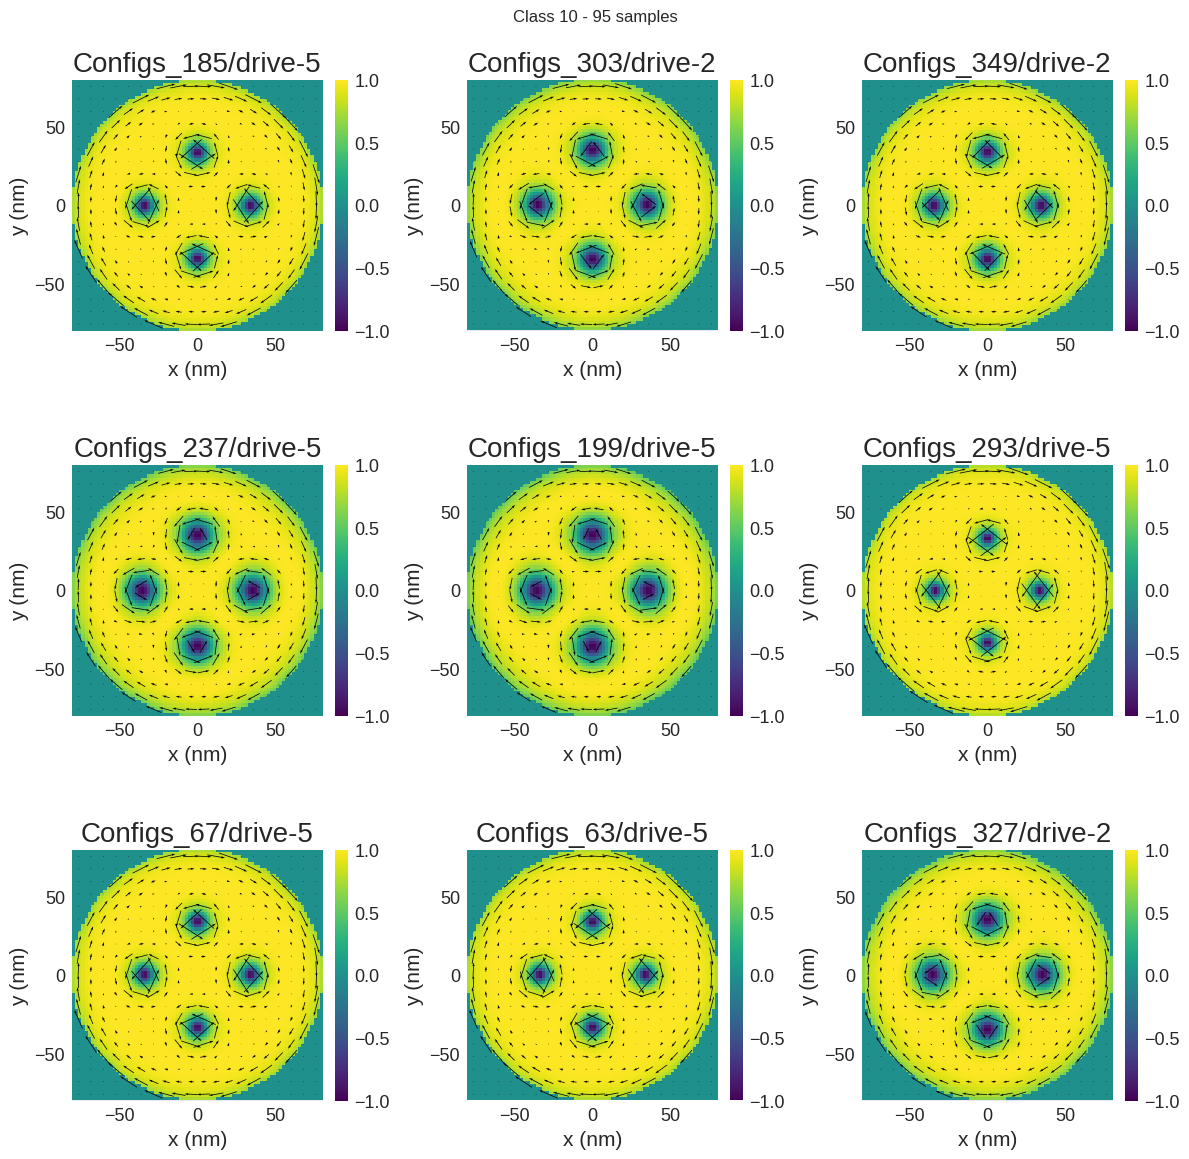

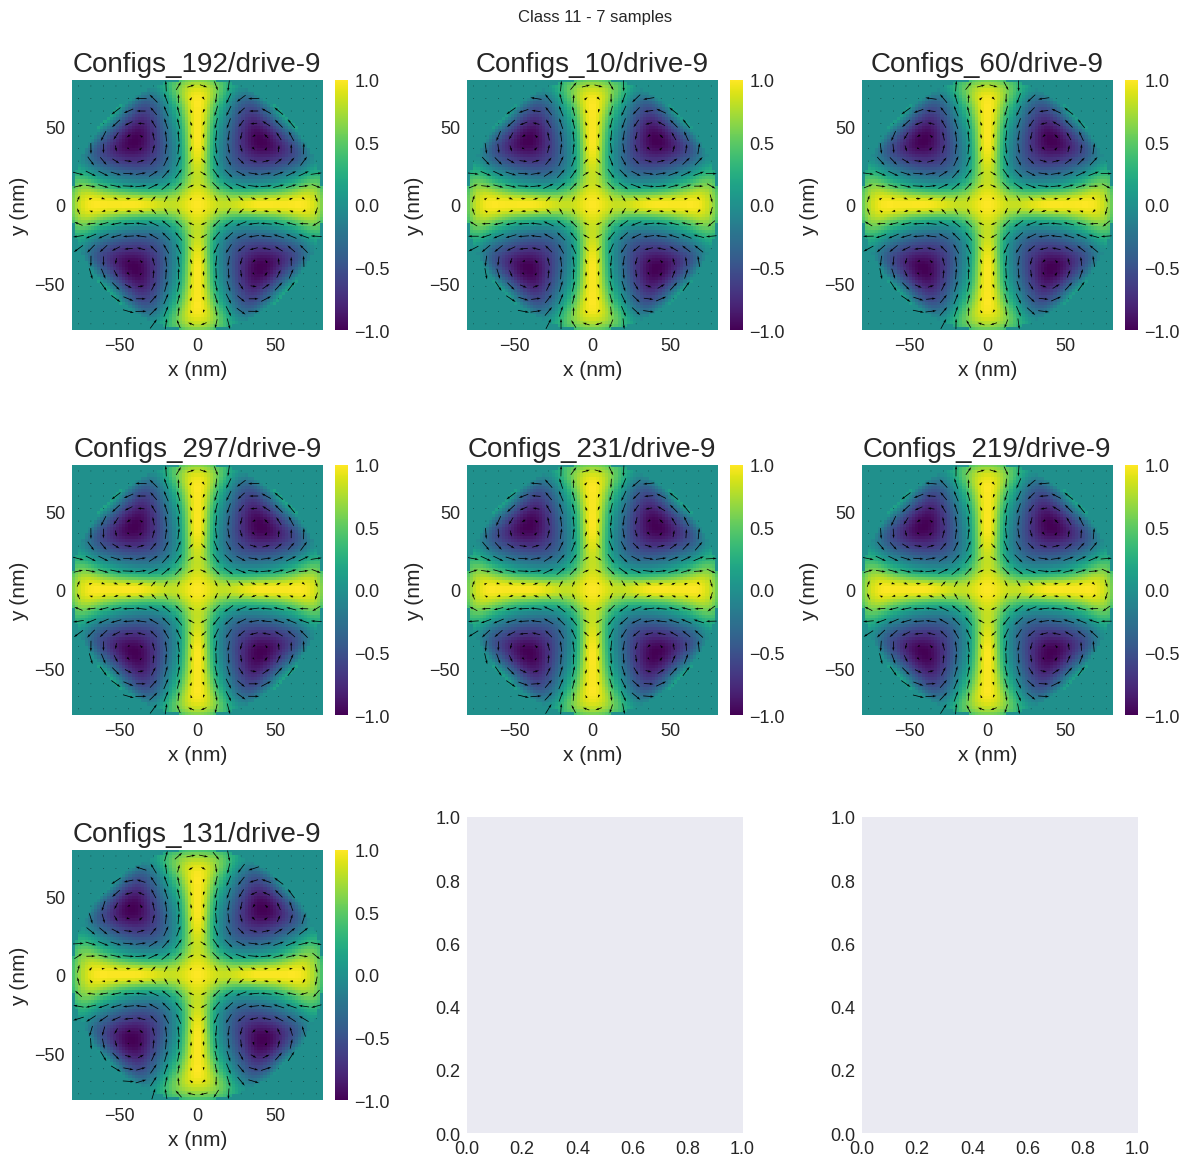

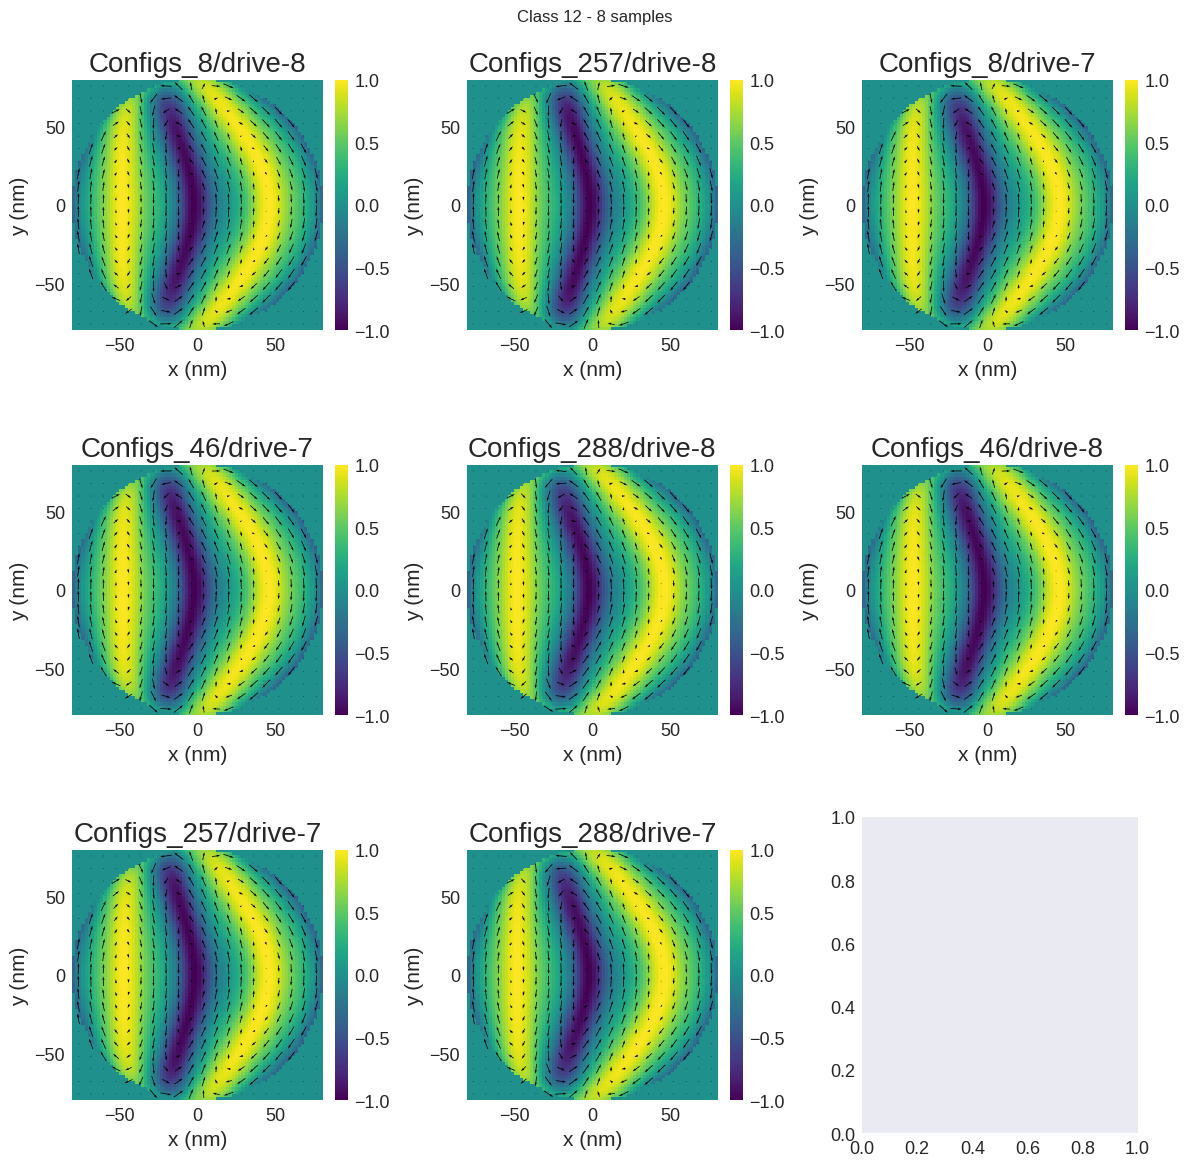

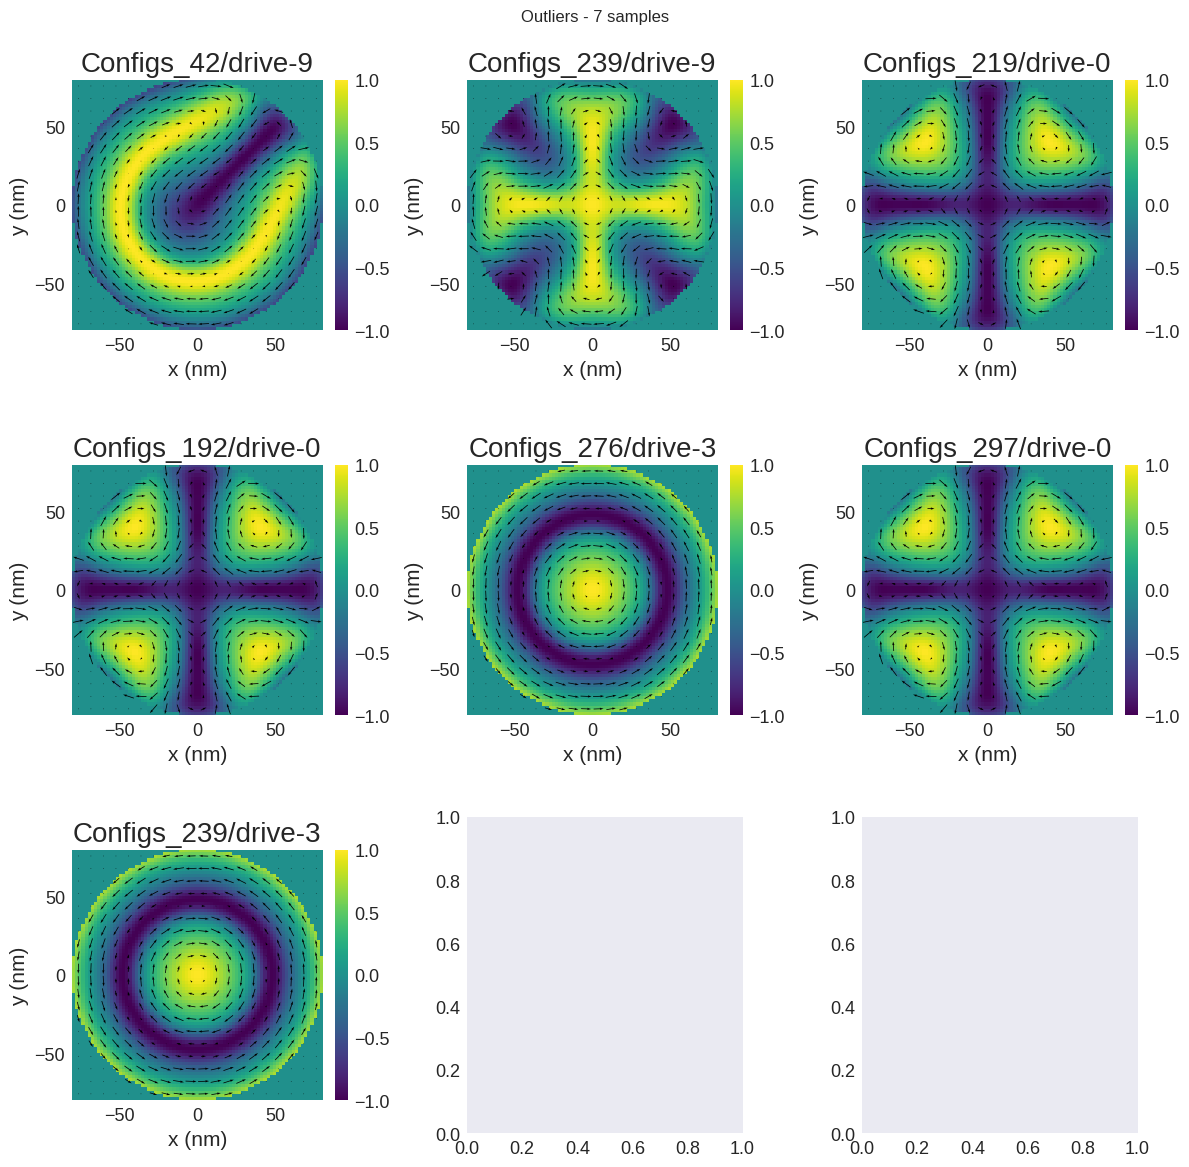

In [127]:
plot_all_examples(class_dict, parameters_dict)